In [6]:
import numpy as np

import torch
from torch import nn
from torch import optim

from torch.utils.data import TensorDataset, DataLoader

#import torchvision.transforms as transforms

#import albumentations as albu
#from albumentations.pytorch import ToTensor

#from PIL import Image

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# PytorchでNNモデルを作成して、学習する手順

## やること
### 1. データの読み込み
### 2. モデルの作成
### 3. 学習
### 4. 評価
### 5. モデルの保存
### 6. 検証

# 1. データの読み込み

## 使うライブラリ
- torch.utils.data.Dataset()
- torch.utils.data.DataLoader()



In [7]:
digits = load_digits()

X = digits.data
y = digits.target

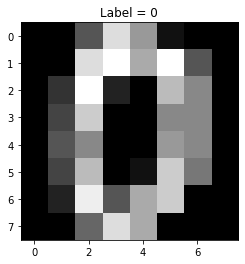

In [8]:
plt.title(f"Label = {y[0]}")
plt.imshow(X[0].reshape(8,8), cmap="gray")
plt.show()

In [22]:
X = X.reshape(-1, 1, 8, 8).astype(np.float32)

In [23]:
#学習用データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)

## 画像

In [24]:
#テンソル型に変換する
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.int64)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64) 

#データセット
train = TensorDataset(X_train, y_train)
valid = TensorDataset(X_valid, y_valid)
test = TensorDataset(X_test, y_test)
 
#データローダー
train_loader = torch.utils.data.DataLoader(train, batch_size = 32, shuffle = False)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size = 32, shuffle = False)

In [33]:
# ネットワークの定義
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet,self).__init__()
        #畳み込み層
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 2, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 2, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),
        )
        #全結合層
        self.dence = nn.Sequential(
            nn.Linear(32 * 4 * 4, 128),
            nn.ReLU(inplace=True),
            #nn.Dropout(p=0.2),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            #nn.Dropout(p=0.2),
            nn.Linear(64, 10),
        )
         
    #順伝播
    def forward(self,x):
         
        out = self.conv_layers(x)
        #Flatten
        out = out.view(out.size(0), -1)
        #全結合層
        out = self.dence(out)
         
        return out
     
    #畳み込み層の出力サイズのチェック
    def check_cnn_size(self, size_check):
        out = self.conv_layers(size_check)
         
        return out

## 確認

In [34]:
#デバイスの状態を確定
device = 'cuda' if torch.cuda.is_available() else 'cpu'
 
#net()をデバイスに渡す
model = CNNNet().to(device)
 
#畳み込み層の出力サイズ=全結合層のinput_sizeの確認
size_check = torch.FloatTensor(10, 1, 8, 8)
size_check = size_check.to(device)
print(model.check_cnn_size(size_check).size())

torch.Size([10, 32, 4, 4])


In [35]:
#==== deviceの選択 ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#==== モデルの定義 ====
model = CNNNet().to(device)

#==== 損失関数の定義 ====
criterion = nn.CrossEntropyLoss()

#==== Optimizerの定義 ====
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [36]:
#==== 学習 ====
def learning(train_loader, val_loader, num_epochs=100):
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []
    
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        valid_loss = 0
        valid_acc = 0
        
        
        #==== 学習 ====
        model.train()
        
        for images, labels in train_loader:
            #==== deviceに渡す
            images = images.to(device)
            labels = labels.to(device)
            
            #==== Optimizerの初期化 ====
            optimizer.zero_grad()
            
            #==== forward processing ====
            outputs = model(images)
            
            #==== Loss calcuration ====
            loss = criterion(outputs, labels)
            
            #==== backward processing ====
            loss.backward()
            
            #==== update optimizer ====
            optimizer.step()
            
            train_loss += loss.item()
            train_acc += (outputs.max(1)[1] == labels).sum().item()
            
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_acc = train_acc / len(train_loader.dataset)
        
        #==== 検証 =====
        model.eval()
        
        #重みを変えさせない
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                valid_loss += loss.item()
                valid_acc += (outputs.max(1)[1] == labels).sum().item()
                
        avg_valid_loss = valid_loss / len(valid_loader.dataset)
        avg_valid_acc = valid_acc / len(valid_loader.dataset)
        
        print(f"=====  epoch: {epoch+1} ===== \
        \n train_loss: {avg_train_loss}, valid_loss: {avg_valid_loss} \
        \n train_acc: {avg_train_acc}, valid_acc: {avg_valid_acc}")
        
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        valid_loss_list.append(avg_valid_loss)
        valid_acc_list.append(avg_valid_acc)
        
    loss_list = [train_loss_list, valid_loss_list]
    acc_list = [train_acc_list, valid_acc_list]
    
    return loss_list, acc_list

In [37]:
loss_list, acc_list = learning(train_loader, valid_loader, 150)

=====  epoch: 1 =====         
 train_loss: 0.060445460632665836, valid_loss: 0.03876636839575238         
 train_acc: 0.37910447761194027, valid_acc: 0.7060185185185185
=====  epoch: 2 =====         
 train_loss: 0.022961809326760212, valid_loss: 0.017535488983547246         
 train_acc: 0.7970149253731343, valid_acc: 0.8402777777777778
=====  epoch: 3 =====         
 train_loss: 0.012019492129781354, valid_loss: 0.01249496964737773         
 train_acc: 0.8955223880597015, valid_acc: 0.8680555555555556
=====  epoch: 4 =====         
 train_loss: 0.007909947166691965, valid_loss: 0.009556836241649257         
 train_acc: 0.9233830845771144, valid_acc: 0.9097222222222222
=====  epoch: 5 =====         
 train_loss: 0.005875925467678563, valid_loss: 0.007361006043437455         
 train_acc: 0.9462686567164179, valid_acc: 0.9305555555555556
=====  epoch: 6 =====         
 train_loss: 0.003925070502049295, valid_loss: 0.006885594214071278         
 train_acc: 0.9641791044776119, valid_acc: 

=====  epoch: 51 =====         
 train_loss: 7.102962393476975e-06, valid_loss: 0.004445926008715846         
 train_acc: 1.0, valid_acc: 0.9629629629629629
=====  epoch: 52 =====         
 train_loss: 6.792442484345259e-06, valid_loss: 0.004348199492799015         
 train_acc: 1.0, valid_acc: 0.9629629629629629
=====  epoch: 53 =====         
 train_loss: 6.498580977907961e-06, valid_loss: 0.0043456473147132245         
 train_acc: 1.0, valid_acc: 0.9629629629629629
=====  epoch: 54 =====         
 train_loss: 6.223864497837555e-06, valid_loss: 0.00434359230793133         
 train_acc: 1.0, valid_acc: 0.9629629629629629
=====  epoch: 55 =====         
 train_loss: 5.988274872594337e-06, valid_loss: 0.00435444526637083         
 train_acc: 1.0, valid_acc: 0.9629629629629629
=====  epoch: 56 =====         
 train_loss: 5.756773211557733e-06, valid_loss: 0.004352846447377319         
 train_acc: 1.0, valid_acc: 0.9629629629629629
=====  epoch: 57 =====         
 train_loss: 5.539988990165

=====  epoch: 103 =====         
 train_loss: 1.4477758428546083e-06, valid_loss: 0.0063011643754483275         
 train_acc: 1.0, valid_acc: 0.9629629629629629
=====  epoch: 104 =====         
 train_loss: 1.4143154106054523e-06, valid_loss: 0.0048674859997980225         
 train_acc: 1.0, valid_acc: 0.9629629629629629
=====  epoch: 105 =====         
 train_loss: 1.379536839087803e-06, valid_loss: 0.004879634462095391         
 train_acc: 1.0, valid_acc: 0.9629629629629629
=====  epoch: 106 =====         
 train_loss: 1.3496388509795441e-06, valid_loss: 0.005948289895160188         
 train_acc: 1.0, valid_acc: 0.9629629629629629
=====  epoch: 107 =====         
 train_loss: 1.316090787332175e-06, valid_loss: 0.00491004082518716         
 train_acc: 1.0, valid_acc: 0.9629629629629629
=====  epoch: 108 =====         
 train_loss: 1.287535505708995e-06, valid_loss: 0.005519174382647584         
 train_acc: 1.0, valid_acc: 0.9629629629629629
=====  epoch: 109 =====         
 train_loss: 1.

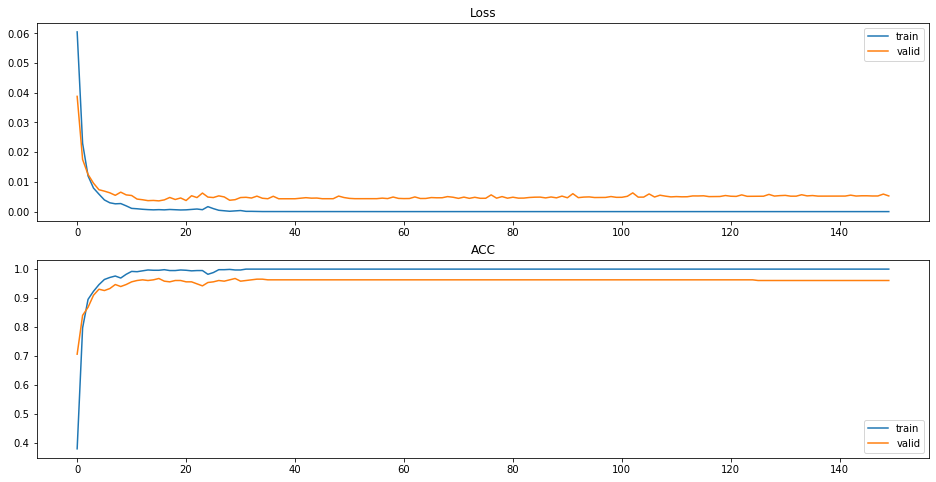

In [38]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(loss_list[0], label="train")
plt.plot(loss_list[1], label="valid")
plt.legend()

plt.subplot(2, 1, 2)
plt.title("ACC")
plt.plot(acc_list[0], label="train")
plt.plot(acc_list[1], label="valid")
plt.legend()

plt.show()

In [195]:
#====== 保存 =======
torch.save(model.state_dict(), "model_cnn.pth")

In [ ]:
model = CNNNet()
#====== ロード =======
model.load_state_dict(torch.load("model_cnn.pth", map_location=device))

In [200]:
def prediction(test_loader):
    pred_list = []
    model.eval()
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model.forward(images)
            _, pred = torch.max(outputs.data, 1)
            pred_list.append(pred.item())
    return pred_list

In [201]:
pred = prediction(test_loader)

In [202]:
from sklearn.metrics import accuracy_score

In [203]:
accuracy_score(pred, y_test)

0.9638888888888889

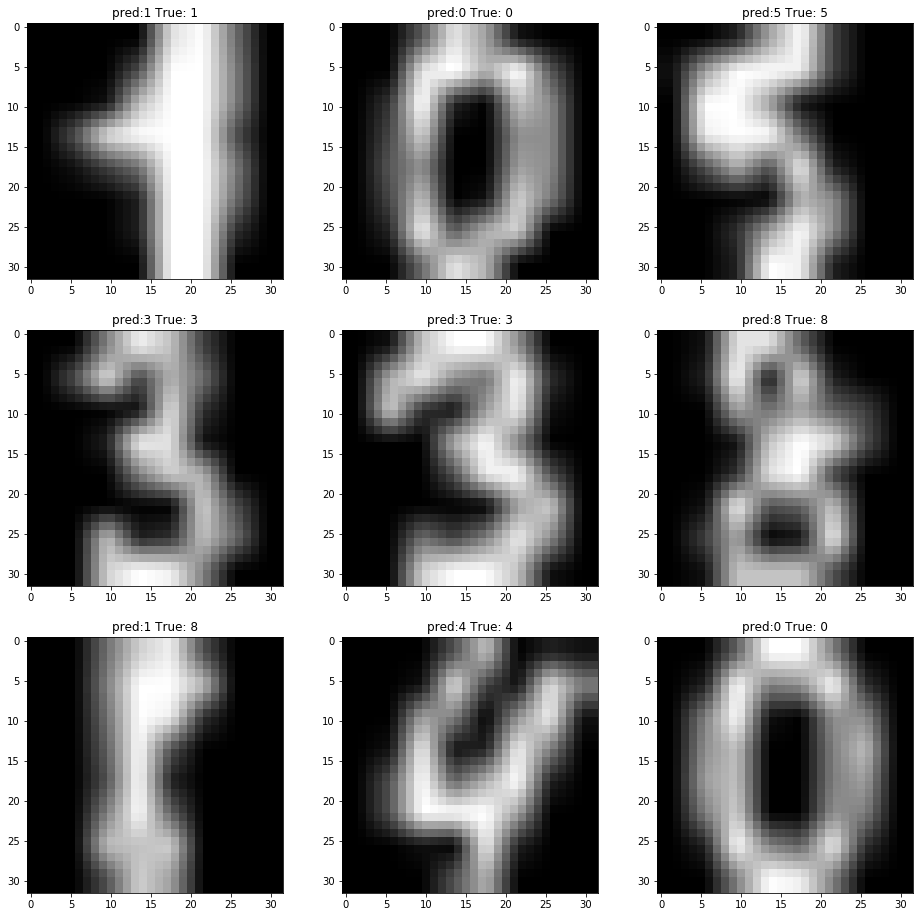

In [221]:
plt.figure(figsize=(16, 16))
for i, image in enumerate(test_loader):
    plt.subplot(3, 3, i+1)
    plt.title(f"pred:{pred[i]} True: {y_test[i]}")
    plt.imshow(image.reshape(32,32), cmap="gray")
    
    if i+1 == 9:
        plt.show()
        break